# Detecting Anomalous Trades in U.S. Congressional Stock Transactions

**Master's Thesis - Economics, Universidad de San Andrés**

---

## Overview

This notebook implements unsupervised anomaly detection on congressional stock trades. The goal is to identify transactions that deviate significantly from typical trading patterns, which may warrant further investigation for potential informed trading.

**Methodology:**
- Isolation Forest (Liu et al., 2008): detects global outliers
- Local Outlier Factor (Breunig et al., 2000): detects contextual outliers

**Validation approach:**
Since we lack ground-truth labels, we validate by testing whether flagged anomalies exhibit higher cumulative abnormal returns (CAR), consistent with informed trading.

---

## 0. Setup

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
import seaborn as sns

# Stats
from scipy import stats

# ML / Preprocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Anomaly Detection
from pyod.models.iforest import IForest
from pyod.models.lof import LOF

# ============================================================
# PLOT STYLE - paper quality
# ============================================================

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.family': 'serif',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 120,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

COLORS = {
    'primary': '#2C3E50',
    'secondary': '#7F8C8D', 
    'accent': '#E74C3C',
    'success': '#27AE60',
    'warning': '#F39C12',
    'dem': '#3498DB',
    'rep': '#E74C3C',
    'ind': '#95A5A6'
}

print('Setup complete.')

Setup complete.


In [3]:
# Load data
df_raw = pd.read_parquet('data/congress_merged.parquet')
print(f'Loaded {len(df_raw):,} observations, {df_raw.shape[1]} variables')

Loaded 80,933 observations, 84 variables


---
## 1. Data Quality Assessment

Before modeling, we need to:
1. Check data types and fix string-encoded numerics
2. Assess missing values and drop variables with >70% NaN
3. Examine correlations to avoid redundant features

This ensures the anomaly detection model receives clean, well-structured input.

### 1.1 Data Types Inspection

In [4]:
# Working copy
df = df_raw.copy()

# All columns with their types
print(f"{'Variable':<30} {'Type':<15} {'Sample Value'}")
print("="*70)
for col in df.columns:
    sample = df[col].dropna().iloc[0] if df[col].notna().any() else 'ALL NA'
    # Truncate long samples
    sample_str = str(sample)[:30] + '...' if len(str(sample)) > 30 else str(sample)
    print(f"{col:<30} {str(df[col].dtype):<15} {sample_str}")

Variable                       Type            Sample Value
ticker                         str             BIN
tickertype                     str             Stock
company                        str             Progressive Waste Solutions Lt...
traded                         str             1/6/2016
transaction                    str             Exchange
trade_size_usd                 str             $15,001 - $50,000
status                         str             New
subholding                     str             
description                    str             
name                           str             Collins, Susan M.
bioguideid                     str             C001035
filed                          str             8/7/2016
district                       str             
quiver_upload_time             str             
excess_return                  str             
state                          str             
last_modified                  str             
ticker_clean   

In [5]:
# ============================================================
# TYPE CONVERSION
# Many numeric variables exported as strings from Stata.
# We convert them systematically.
# ============================================================

# Variables that SHOULD be numeric
numeric_vars = [
    # Returns
    'excess_return', 'return_t', 'abs_return_t', 'return_overnight', 'return_intraday',
    # Momentum
    'momentum_5d', 'momentum_20d', 'momentum_60d', 'momentum_252d',
    # Volatility
    'realized_vol_30d', 'parkinson_vol_30d', 'realized_vol_60d', 
    'vol_of_vol_60d', 'realized_vol_252d',
    # Volume
    'volume_t', 'dollar_volume_t', 'volume_ratio_30d', 'abnormal_volume_30d',
    # Liquidity
    'amihud_illiq_20d', 'roll_spread_30d', 'hl_spread_20d', 'zero_volume_days_30d',
    # Risk
    'beta_252d', 'r2_market_252d',
    # Valuation
    'market_cap', 'price', 'book_value', 'price_to_book', 'ev_to_ebitda',
    # CAR
    'car_raw_30d', 'car_capm_30d', 'car_raw_60d', 'car_capm_60d', 
    'car_raw_90d', 'car_capm_90d'
]

converted = []
for var in numeric_vars:
    if var in df.columns:
        original_type = df[var].dtype
        df[var] = pd.to_numeric(df[var], errors='coerce')
        if str(original_type) != str(df[var].dtype):
            converted.append(var)

print(f"Converted {len(converted)} variables to numeric:")
print(converted[:10], '...' if len(converted) > 10 else '')

Converted 24 variables to numeric:
['excess_return', 'return_t', 'abs_return_t', 'return_overnight', 'momentum_60d', 'realized_vol_30d', 'parkinson_vol_30d', 'realized_vol_60d', 'vol_of_vol_60d', 'realized_vol_252d'] ...


In [6]:
# ============================================================
# DATE CONVERSION
# ============================================================

if 'traded' in df.columns:
    df['traded_date'] = pd.to_datetime(df['traded'], dayfirst=True, errors='coerce')
    df['trade_year'] = df['traded_date'].dt.year
    df['trade_month'] = df['traded_date'].dt.month
    print(f"Trade dates parsed: {df['traded_date'].notna().sum():,} valid")

if 'filed' in df.columns:
    df['filed_date'] = pd.to_datetime(df['filed'], dayfirst=True, errors='coerce')
    print(f"Filed dates parsed: {df['filed_date'].notna().sum():,} valid")

# Filing delay
if 'traded_date' in df.columns and 'filed_date' in df.columns:
    df['filing_delay'] = (df['filed_date'] - df['traded_date']).dt.days
    df.loc[df['filing_delay'] < 0, 'filing_delay'] = np.nan
    df.loc[df['filing_delay'] > 365, 'filing_delay'] = np.nan
    print(f"Filing delay computed: {df['filing_delay'].notna().sum():,} valid")

Trade dates parsed: 80,933 valid
Filed dates parsed: 80,933 valid
Filing delay computed: 79,398 valid


In [7]:
# ============================================================
# CATEGORICAL CONVERSION
# Stata categoricals need to be converted to string
# ============================================================

categorical_vars = ['party', 'chamber', 'transaction', 'state']

for var in categorical_vars:
    if var in df.columns:
        df[f'{var}_label'] = df[var].astype(str)
        print(f"{var}: {df[f'{var}_label'].nunique()} unique values")

party: 3 unique values
chamber: 2 unique values
transaction: 7 unique values
state: 47 unique values


### 1.2 Missing Values Analysis

In [8]:
# ============================================================
# MISSING VALUES REPORT
# Calculate % missing for each variable
# ============================================================

missing_report = []

for col in df.columns:
    n_total = len(df)
    n_missing = df[col].isna().sum()
    n_valid = n_total - n_missing
    pct_missing = n_missing / n_total * 100
    pct_valid = n_valid / n_total * 100
    
    missing_report.append({
        'variable': col,
        'dtype': str(df[col].dtype),
        'n_valid': n_valid,
        'n_missing': n_missing,
        'pct_valid': pct_valid,
        'pct_missing': pct_missing
    })

missing_df = pd.DataFrame(missing_report).sort_values('pct_missing', ascending=False)
missing_df = missing_df.reset_index(drop=True)

print(f"{'Variable':<30} {'Type':<12} {'Valid':>10} {'Missing %':>12}")
print("="*70)
for _, row in missing_df.iterrows():
    print(f"{row['variable']:<30} {row['dtype']:<12} {row['n_valid']:>10,} {row['pct_missing']:>11.1f}%")

Variable                       Type              Valid    Missing %
volume_t                       float32               0       100.0%
return_t                       float64               0       100.0%
return_overnight               float64               0       100.0%
return_intraday                float32               0       100.0%
momentum_5d                    float32               0       100.0%
momentum_20d                   float64               0       100.0%
momentum_60d                   float64               0       100.0%
momentum_252d                  float32               0       100.0%
abs_return_t                   float64               0       100.0%
dollar_volume_t                float32               0       100.0%
volume_ratio_30d               float32               0       100.0%
abnormal_volume_30d            float32               0       100.0%
market_cap                     float64             453        99.4%
excess_return                  float64          

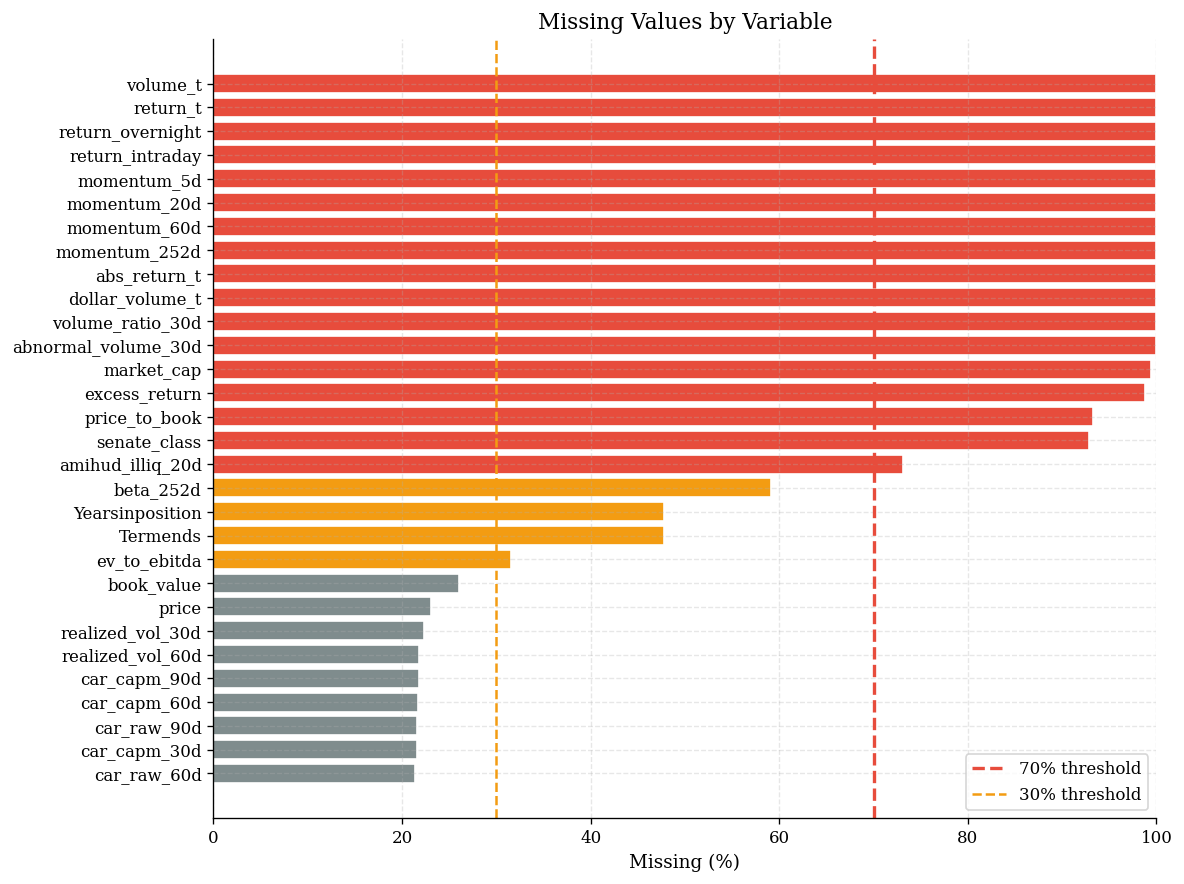

In [9]:
# ============================================================
# FIGURE: Missing Values by Variable
# ============================================================

# Only show variables with some missing data, sorted
missing_vars = missing_df[missing_df['pct_missing'] > 0].copy()

if len(missing_vars) > 0:
    # Limit to top 30 for readability
    plot_data = missing_vars.head(30).sort_values('pct_missing')
    
    fig, ax = plt.subplots(figsize=(10, max(6, len(plot_data)*0.25)))
    
    colors = [COLORS['accent'] if x > 70 else COLORS['warning'] if x > 30 else COLORS['secondary'] 
              for x in plot_data['pct_missing']]
    
    ax.barh(plot_data['variable'], plot_data['pct_missing'], color=colors, edgecolor='white')
    ax.axvline(70, color=COLORS['accent'], linestyle='--', linewidth=2, label='70% threshold')
    ax.axvline(30, color=COLORS['warning'], linestyle='--', linewidth=1.5, label='30% threshold')
    
    ax.set_xlabel('Missing (%)')
    ax.set_title('Missing Values by Variable')
    ax.legend(loc='lower right')
    ax.set_xlim(0, 100)
    
    plt.tight_layout()
    plt.savefig('fig_missing_values.png', dpi=300)
    plt.show()
else:
    print("No missing values found.")

In [ ]:
# ============================================================
# IDENTIFY VARIABLES TO DROP (>70% missing)
# ============================================================

MISSING_THRESHOLD = 70  # percent

vars_to_drop = missing_df[missing_df['pct_missing'] > MISSING_THRESHOLD]['variable'].tolist()

print(f"Variables with >{MISSING_THRESHOLD}% missing ({len(vars_to_drop)} total):")
print("-"*50)
for var in vars_to_drop:
    pct = missing_df[missing_df['variable']==var]['pct_missing'].values[0]
    print(f"  {var}: {pct:.1f}% missing")

# Variables to keep for potential model use
vars_usable = missing_df[missing_df['pct_missing'] <= MISSING_THRESHOLD]['variable'].tolist()
print(f"\nVariables with ≤{MISSING_THRESHOLD}% missing: {len(vars_usable)}")

In [ ]:
# ============================================================
# NUMERIC VARIABLES QUALITY CHECK
# For model features, we want >30% valid data minimum
# ============================================================

# Focus on variables we'd want for the model
potential_features = [
    # Returns
    'excess_return', 'return_t', 'return_overnight', 'return_intraday',
    # Momentum  
    'momentum_5d', 'momentum_20d', 'momentum_60d', 'momentum_252d',
    # Volatility
    'realized_vol_30d', 'parkinson_vol_30d', 'realized_vol_60d', 
    'vol_of_vol_60d', 'realized_vol_252d',
    # Volume
    'volume_t', 'dollar_volume_t', 'volume_ratio_30d', 'abnormal_volume_30d',
    # Liquidity
    'amihud_illiq_20d', 'roll_spread_30d', 'hl_spread_20d', 'zero_volume_days_30d',
    # Risk
    'beta_252d', 'r2_market_252d',
    # Valuation
    'market_cap', 'price', 'price_to_book', 'ev_to_ebitda',
    # CAR
    'car_raw_30d', 'car_capm_30d', 'car_raw_60d', 'car_capm_60d',
    # Created
    'filing_delay'
]

print(f"{'Feature':<25} {'Valid':>10} {'Valid %':>10} {'Status':<15}")
print("="*65)

feature_quality = []
for feat in potential_features:
    if feat in df.columns:
        n_valid = df[feat].notna().sum()
        pct_valid = n_valid / len(df) * 100
        
        if pct_valid >= 70:
            status = '✓ Good'
        elif pct_valid >= 30:
            status = '~ Usable'
        else:
            status = '✗ Drop'
        
        feature_quality.append({
            'feature': feat,
            'n_valid': n_valid,
            'pct_valid': pct_valid,
            'status': status
        })
        print(f"{feat:<25} {n_valid:>10,} {pct_valid:>9.1f}% {status:<15}")
    else:
        print(f"{feat:<25} {'NOT FOUND':>10}")

feature_quality_df = pd.DataFrame(feature_quality)

In [ ]:
# ============================================================
# DEFINE USABLE FEATURES FOR MODEL
# Keep only features with >30% valid data
# ============================================================

MIN_VALID_PCT = 30

features_usable = feature_quality_df[
    feature_quality_df['pct_valid'] >= MIN_VALID_PCT
]['feature'].tolist()

features_dropped = feature_quality_df[
    feature_quality_df['pct_valid'] < MIN_VALID_PCT
]['feature'].tolist()

print(f"Features usable (≥{MIN_VALID_PCT}% valid): {len(features_usable)}")
print(features_usable)

print(f"\nFeatures dropped (<{MIN_VALID_PCT}% valid): {len(features_dropped)}")
print(features_dropped)

### 1.3 Correlation Analysis

In [ ]:
# ============================================================
# CORRELATION MATRIX - Usable features only
# ============================================================

# Filter to features that exist and have data
corr_features = [f for f in features_usable if f in df.columns]

corr_matrix = df[corr_features].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.6, 'label': 'Correlation'},
            vmin=-1, vmax=1, ax=ax,
            annot=True, fmt='.1f', annot_kws={'size': 8})

ax.set_title('Correlation Matrix - Usable Features', fontsize=13, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('fig_correlation_matrix.png', dpi=300)
plt.show()

In [ ]:
# ============================================================
# HIGHLY CORRELATED PAIRS (|r| > 0.8)
# These indicate redundant information - we should keep only one
# ============================================================

HIGH_CORR_THRESHOLD = 0.8

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > HIGH_CORR_THRESHOLD:
            high_corr_pairs.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': round(r, 3)
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', 
                                                              key=abs, ascending=False)
    print(f"Highly correlated pairs (|r| > {HIGH_CORR_THRESHOLD}):")
    print("="*60)
    print(high_corr_df.to_string(index=False))
    
    print("\n→ Recommendation: Keep one variable from each correlated pair")
else:
    print(f"No pairs with |r| > {HIGH_CORR_THRESHOLD}")

In [ ]:
# ============================================================
# CORRELATION BY VARIABLE FAMILY
# Check correlation within families to select representatives
# ============================================================

families = {
    'Volatility': ['realized_vol_30d', 'parkinson_vol_30d', 'realized_vol_60d', 
                   'vol_of_vol_60d', 'realized_vol_252d'],
    'Momentum': ['momentum_5d', 'momentum_20d', 'momentum_60d', 'momentum_252d'],
    'CAR': ['car_raw_30d', 'car_capm_30d', 'car_raw_60d', 'car_capm_60d'],
    'Volume': ['volume_t', 'dollar_volume_t', 'volume_ratio_30d', 'abnormal_volume_30d'],
    'Liquidity': ['amihud_illiq_20d', 'roll_spread_30d', 'hl_spread_20d']
}

for family_name, family_vars in families.items():
    # Filter to vars that exist and have data
    existing = [v for v in family_vars if v in df.columns and df[v].notna().sum() > 0]
    
    if len(existing) >= 2:
        family_corr = df[existing].corr()
        
        print(f"\n{family_name} family:")
        print(family_corr.round(2).to_string())

### 1.4 Final Feature Selection

In [ ]:
# ============================================================
# FINAL FEATURE SET FOR MODEL
# Selection criteria:
# 1. >30% valid data
# 2. One variable per highly correlated family
# 3. Theoretical relevance for insider trading detection
# ============================================================

# Based on the analysis above, select final features:
features_final = [
    # Abnormal return - key outcome
    'car_raw_30d',
    
    # Volatility - one representative
    'realized_vol_30d',
    
    # Risk
    'beta_252d',
    
    # Timing - strategic disclosure
    'filing_delay',
    
    # Volume (if available)
    'volume_ratio_30d',
    
    # Liquidity (if available)
    'amihud_illiq_20d',
    
    # Momentum (if available)
    'momentum_5d',
]

# Keep only those that exist and have >30% data
features_model = []
for f in features_final:
    if f in df.columns:
        pct_valid = df[f].notna().mean() * 100
        if pct_valid >= 30:
            features_model.append(f)
            print(f"✓ {f}: {pct_valid:.1f}% valid")
        else:
            print(f"✗ {f}: {pct_valid:.1f}% valid (dropped)")
    else:
        print(f"✗ {f}: not found")

print(f"\nFinal features for model: {len(features_model)}")
print(features_model)

### 1.5 Summary Statistics - Final Features

In [ ]:
# Descriptive statistics for final features
df[features_model].describe().T.round(4)

In [ ]:
# ============================================================
# FIGURE: Distribution of Final Features
# ============================================================

n_features = len(features_model)
n_cols = min(3, n_features)
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for i, var in enumerate(features_model):
    ax = axes[i]
    data = df[var].dropna()
    
    # Winsorize for visualization
    q01, q99 = data.quantile([0.01, 0.99])
    data_plot = data[(data >= q01) & (data <= q99)]
    
    ax.hist(data_plot, bins=50, color=COLORS['primary'], edgecolor='white', alpha=0.8)
    ax.axvline(data.median(), color=COLORS['accent'], linestyle='--', linewidth=2, label='Median')
    ax.set_title(var.replace('_', ' ').title())
    ax.legend(fontsize=8)

# Hide empty subplots
for j in range(n_features, len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribution of Model Features (Winsorized 1%-99%)', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('fig_feature_distributions.png', dpi=300)
plt.show()

---
## 2. Exploratory Data Analysis

In [ ]:
# Basic dimensions
print(f"Total trades: {len(df):,}")
print(f"Unique politicians: {df['name'].nunique():,}")
print(f"Unique tickers: {df['ticker'].nunique():,}")

if 'trade_year' in df.columns:
    valid_years = df['trade_year'].dropna()
    print(f"Date range: {valid_years.min():.0f} - {valid_years.max():.0f}")

In [ ]:
# ============================================================
# FIGURE: Trading Activity Over Time
# ============================================================

if 'trade_year' in df.columns:
    fig, ax = plt.subplots(figsize=(10, 4))
    
    yearly = df.groupby('trade_year').size()
    ax.bar(yearly.index, yearly.values, color=COLORS['primary'], edgecolor='white', linewidth=0.5)
    
    # Mark STOCK Act (2012)
    if 2012 in yearly.index:
        ax.axvline(2012, color=COLORS['accent'], linestyle='--', linewidth=1.5, alpha=0.8)
        ax.text(2012.2, ax.get_ylim()[1]*0.9, 'STOCK Act', fontsize=9, color=COLORS['accent'])
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Trades')
    ax.set_title('Congressional Stock Trading Activity by Year')
    
    plt.tight_layout()
    plt.savefig('fig_trading_activity.png', dpi=300)
    plt.show()

In [ ]:
# ============================================================
# FIGURE: Distribution by Party and Chamber
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Party distribution
party_counts = df['party_label'].value_counts()
party_colors = [COLORS['dem'] if 'Dem' in str(p) else COLORS['rep'] if 'Rep' in str(p) else COLORS['ind'] 
                for p in party_counts.index]

axes[0].barh(party_counts.index, party_counts.values, color=party_colors, edgecolor='white')
axes[0].set_xlabel('Number of Trades')
axes[0].set_title('Trades by Party')

# Chamber distribution
chamber_counts = df['chamber_label'].value_counts()
axes[1].barh(chamber_counts.index, chamber_counts.values, color=COLORS['primary'], edgecolor='white')
axes[1].set_xlabel('Number of Trades')
axes[1].set_title('Trades by Chamber')

plt.tight_layout()
plt.savefig('fig_party_chamber.png', dpi=300)
plt.show()

In [ ]:
# Transaction types
print("Transaction types:")
print(df['transaction_label'].value_counts())

---
## 3. Model Preparation

In [ ]:
# ============================================================
# PREPARE MODELING DATASET
# Keep identifying columns + features, then drop NAs
# ============================================================

id_cols = ['trade_id', 'name', 'party_label', 'chamber_label', 'ticker', 
           'transaction_label', 'traded_date', 'trade_year', 'committee']
id_cols = [c for c in id_cols if c in df.columns]

df_model = df[id_cols + features_model].copy()

print(f"Before dropping NAs: {len(df_model):,}")
df_model = df_model.dropna(subset=features_model)
print(f"After dropping NAs:  {len(df_model):,}")
print(f"Retention rate: {len(df_model)/len(df)*100:.1f}%")

In [ ]:
# Feature matrix
X = df_model[features_model].copy()

# Handle infinities
X = X.replace([np.inf, -np.inf], np.nan)
valid_idx = X.dropna().index
df_model = df_model.loc[valid_idx]
X = X.loc[valid_idx]

print(f"Final sample: {len(df_model):,} trades")
print(f"Feature matrix: {X.shape}")

In [ ]:
# ============================================================
# SCALING
# RobustScaler uses median/IQR - better for heavy-tailed data
# ============================================================

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled feature matrix: {X_scaled.shape}")
print(f"Post-scaling mean (should be ~0): {X_scaled.mean(axis=0).round(2)}")

---
## 4. Anomaly Detection Model

### Configuration

- **contamination = 0.05**: We assume ~5% of trades may be anomalous (conservative)
- **n_estimators = 200**: Standard for Isolation Forest
- **n_neighbors = 1% of sample**: For LOF local density estimation

In [ ]:
# Model parameters
CONTAMINATION = 0.05
RANDOM_STATE = 42
N_ESTIMATORS = 200
N_NEIGHBORS = max(20, int(len(X_scaled) * 0.01))

print(f"Configuration:")
print(f"  Contamination: {CONTAMINATION}")
print(f"  IF n_estimators: {N_ESTIMATORS}")
print(f"  LOF n_neighbors: {N_NEIGHBORS}")

In [ ]:
# ============================================================
# ISOLATION FOREST
# ============================================================

clf_if = IForest(
    contamination=CONTAMINATION,
    n_estimators=N_ESTIMATORS,
    max_samples='auto',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

clf_if.fit(X_scaled)

df_model['score_if'] = clf_if.decision_scores_
df_model['anomaly_if'] = clf_if.labels_

n_anom_if = df_model['anomaly_if'].sum()
print(f"Isolation Forest: {n_anom_if:,} anomalies ({n_anom_if/len(df_model)*100:.1f}%)")

In [ ]:
# ============================================================
# LOCAL OUTLIER FACTOR
# ============================================================

clf_lof = LOF(
    n_neighbors=N_NEIGHBORS,
    contamination=CONTAMINATION,
    n_jobs=-1
)

clf_lof.fit(X_scaled)

df_model['score_lof'] = clf_lof.decision_scores_
df_model['anomaly_lof'] = clf_lof.labels_

n_anom_lof = df_model['anomaly_lof'].sum()
print(f"LOF: {n_anom_lof:,} anomalies ({n_anom_lof/len(df_model)*100:.1f}%)")

In [ ]:
# ============================================================
# COMBINED SCORE
# ============================================================

scaler_mm = MinMaxScaler()
scores_norm = scaler_mm.fit_transform(df_model[['score_if', 'score_lof']])

df_model['score_if_norm'] = scores_norm[:, 0]
df_model['score_lof_norm'] = scores_norm[:, 1]
df_model['score_combined'] = (scores_norm[:, 0] + scores_norm[:, 1]) / 2

# Conservative: anomaly in BOTH methods
df_model['anomaly_both'] = ((df_model['anomaly_if'] == 1) & 
                            (df_model['anomaly_lof'] == 1)).astype(int)

n_anom_both = df_model['anomaly_both'].sum()
print(f"Consensus (both): {n_anom_both:,} anomalies ({n_anom_both/len(df_model)*100:.2f}%)")

agreement = (df_model['anomaly_if'] == df_model['anomaly_lof']).mean()
print(f"IF-LOF agreement: {agreement*100:.1f}%")

In [ ]:
# ============================================================
# FIGURE: Anomaly Score Distributions
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(13, 4))

for ax, (score_col, title) in zip(axes, [
    ('score_if_norm', 'Isolation Forest'),
    ('score_lof_norm', 'Local Outlier Factor'),
    ('score_combined', 'Combined Score')
]):
    ax.hist(df_model[score_col], bins=50, color=COLORS['primary'], 
            edgecolor='white', alpha=0.8)
    q95 = df_model[score_col].quantile(0.95)
    ax.axvline(q95, color=COLORS['accent'], linestyle='--', linewidth=2, label='95th pctl')
    ax.set_xlabel('Anomaly Score')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend()

plt.suptitle('Distribution of Anomaly Scores', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('fig_score_distributions.png', dpi=300)
plt.show()

In [ ]:
# ============================================================
# FIGURE: IF vs LOF Score Comparison
# ============================================================

fig, ax = plt.subplots(figsize=(7, 6))

normal = df_model[df_model['anomaly_both'] == 0]
anomalies = df_model[df_model['anomaly_both'] == 1]

ax.scatter(normal['score_if_norm'], normal['score_lof_norm'], 
           s=8, alpha=0.3, c=COLORS['secondary'], label='Normal')
ax.scatter(anomalies['score_if_norm'], anomalies['score_lof_norm'], 
           s=25, alpha=0.8, c=COLORS['accent'], label='Anomaly (both)', 
           edgecolors='white', linewidth=0.5)

ax.set_xlabel('Isolation Forest Score')
ax.set_ylabel('LOF Score')
ax.set_title('Model Agreement: IF vs LOF')
ax.legend(loc='lower right')

r = df_model['score_if_norm'].corr(df_model['score_lof_norm'])
ax.text(0.05, 0.95, f'r = {r:.2f}', transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('fig_if_vs_lof.png', dpi=300)
plt.show()

---
## 5. Validation

In [ ]:
# ============================================================
# Do anomalies have higher abnormal returns?
# ============================================================

if 'car_raw_30d' in df_model.columns:
    car_col = 'car_raw_30d'
    
    normal_car = df_model[df_model['anomaly_both']==0][car_col]
    anomaly_car = df_model[df_model['anomaly_both']==1][car_col]
    
    print("CAR Comparison: Normal vs Anomalous Trades")
    print("="*50)
    print(f"Normal trades:  mean={normal_car.mean():.4f}, median={normal_car.median():.4f}, n={len(normal_car):,}")
    print(f"Anomaly trades: mean={anomaly_car.mean():.4f}, median={anomaly_car.median():.4f}, n={len(anomaly_car):,}")
    print(f"Difference:     {anomaly_car.mean() - normal_car.mean():.4f}")
    
    # T-test
    t_stat, p_val = stats.ttest_ind(normal_car.dropna(), anomaly_car.dropna())
    print(f"\nT-test: t={t_stat:.3f}, p-value={p_val:.4f}")
    
    if p_val < 0.05:
        print("→ Statistically significant difference at α=0.05")
    else:
        print("→ No statistically significant difference")

In [ ]:
# ============================================================
# FIGURE: CAR Comparison
# ============================================================

if 'car_raw_30d' in df_model.columns:
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
    
    # Boxplot
    box_data = [normal_car.dropna(), anomaly_car.dropna()]
    bp = axes[0].boxplot(box_data, labels=['Normal', 'Anomaly'], patch_artist=True,
                         widths=0.6, showfliers=False)
    bp['boxes'][0].set_facecolor(COLORS['secondary'])
    bp['boxes'][1].set_facecolor(COLORS['accent'])
    axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[0].set_ylabel('CAR 30d')
    axes[0].set_title('Distribution of Abnormal Returns')
    
    # KDE
    clip_low, clip_high = -0.3, 0.3
    normal_clip = normal_car[(normal_car >= clip_low) & (normal_car <= clip_high)]
    anomaly_clip = anomaly_car[(anomaly_car >= clip_low) & (anomaly_car <= clip_high)]
    
    if len(normal_clip) > 10:
        normal_clip.plot.kde(ax=axes[1], color=COLORS['secondary'], linewidth=2, label='Normal')
    if len(anomaly_clip) > 10:
        anomaly_clip.plot.kde(ax=axes[1], color=COLORS['accent'], linewidth=2, label='Anomaly')
    
    axes[1].axvline(0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_xlabel('CAR 30d')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Density Comparison')
    axes[1].legend()
    axes[1].set_xlim(clip_low, clip_high)
    
    plt.suptitle('Cumulative Abnormal Returns: Normal vs Anomalous', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.savefig('fig_car_comparison.png', dpi=300)
    plt.show()

---
## 6. Results Characterization

In [ ]:
# Top 20 most anomalous trades
display_cols = ['name', 'party_label', 'ticker', 'trade_year', 'score_combined']
display_cols = [c for c in display_cols if c in df_model.columns]

print("Top 20 Most Anomalous Trades:")
df_model.nlargest(20, 'score_combined')[display_cols + features_model]

In [ ]:
# Anomaly rate by party
party_stats = df_model.groupby('party_label').agg({
    'anomaly_both': ['sum', 'mean', 'count']
}).round(4)
party_stats.columns = ['N Anomalies', 'Rate', 'Total']

print("Anomaly Rate by Party:")
print(party_stats)

In [ ]:
# Top politicians by anomaly rate (min 20 trades)
MIN_TRADES = 20

politician_stats = df_model.groupby('name').agg({
    'anomaly_both': ['sum', 'mean'],
    'score_combined': 'mean',
    'trade_id': 'count',
    'party_label': 'first'
})
politician_stats.columns = ['N_Anom', 'Rate', 'Avg_Score', 'Trades', 'Party']
politician_stats = politician_stats[politician_stats['Trades'] >= MIN_TRADES]

print(f"Top 15 Politicians by Anomaly Rate (min {MIN_TRADES} trades):")
print(politician_stats.nlargest(15, 'Rate').round(4))

In [ ]:
# ============================================================
# FIGURE: Top Politicians
# ============================================================

top15 = politician_stats.nlargest(15, 'Rate').reset_index()

fig, ax = plt.subplots(figsize=(10, 6))

colors = [COLORS['dem'] if 'Dem' in str(p) else COLORS['rep'] if 'Rep' in str(p) else COLORS['ind'] 
          for p in top15['Party']]

bars = ax.barh(range(len(top15)), top15['Rate'] * 100, color=colors, edgecolor='white')
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15['name'])
ax.set_xlabel('Anomaly Rate (%)')
ax.set_title(f'Politicians with Highest Anomaly Rates (min. {MIN_TRADES} trades)')

for i, row in top15.iterrows():
    ax.annotate(f"n={row['Trades']:.0f}", 
                xy=(row['Rate']*100 + 0.3, i),
                va='center', fontsize=9, color=COLORS['secondary'])

legend_elements = [Line2D([0], [0], color=COLORS['dem'], lw=8, label='Democrat'),
                   Line2D([0], [0], color=COLORS['rep'], lw=8, label='Republican')]
ax.legend(handles=legend_elements, loc='lower right')

ax.invert_yaxis()
plt.tight_layout()
plt.savefig('fig_top_politicians.png', dpi=300)
plt.show()

---
## 7. Export Results

In [ ]:
# Save results
output_cols = ['name', 'party_label', 'chamber_label', 'ticker', 
               'traded_date', 'trade_year',
               'score_if', 'score_lof', 'score_combined',
               'anomaly_if', 'anomaly_lof', 'anomaly_both'] + features_model

output_cols = [c for c in output_cols if c in df_model.columns]

df_model[output_cols].to_csv('congress_anomaly_results.csv', index=False)
print('Saved: congress_anomaly_results.csv')

In [ ]:
# Summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Sample: {len(df_model):,} trades")
print(f"Features: {len(features_model)}")
print(f"Anomalies (IF): {df_model['anomaly_if'].sum():,} ({df_model['anomaly_if'].mean()*100:.1f}%)")
print(f"Anomalies (LOF): {df_model['anomaly_lof'].sum():,} ({df_model['anomaly_lof'].mean()*100:.1f}%)")
print(f"Anomalies (both): {df_model['anomaly_both'].sum():,} ({df_model['anomaly_both'].mean()*100:.2f}%)")
print("="*60)